In [67]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import bmxobs
from matplotlib.colors import LogNorm

In [2]:
d = bmxobs.BMXObs("pas/210603_0600", channels="110,220,120")

In [28]:
def get_cross_cut (D, fmin, fmax, ravg=10, ramin = 5.23-0.2, ramax=5.23+0.2, chan=120):
    freqcut = np.where((D.freq[0]>fmin) & (D.freq[0]<fmax))[0]
    data = D[chan][:,freqcut]
    # average in freq
    data = data.mean(axis=1)
    racut = np.where((D.ra>ramin) & (D.ra<=ramax))[0]
    racut = racut[:len(racut)//ravg*ravg]
    # average in ra
    data = data[racut]
    data=data.reshape((-1,ravg)).mean(axis=1)
    ra = D.ra[racut].reshape((-1,ravg)).mean(axis=1)    
    return ra,data
    

In [50]:
ra,data = get_cross_cut(d,1400,1405)
ra2,data2 = get_cross_cut(d,1500,1505)
data.shape

(562,)

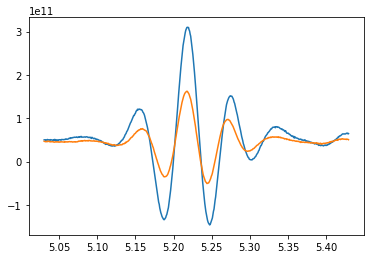

In [36]:
plt.plot(ra,np.imag(data))
plt.plot(ra2,np.imag(data2))

In [51]:
def cross_model(ra, ra0,ofsreal, ofsimag, A, phi, omega, sigma):
    return ofsreal+1j*ofsimag+A*np.exp(1j*(phi+omega*(ra-ra0)))*np.exp(-(ra-ra0)**2/(2*sigma**2))

/gpfs02/astro/packages/bacon/latest/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


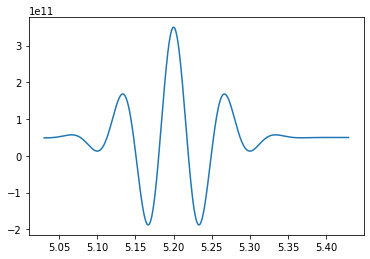

In [61]:
plt.plot(ra,cross_model(ra,5.2,+5e10,1e10,3e11,0,90,0.05))

In [87]:
class Fitter:
    def __init__ (self, ra, data):
        self.ra = ra
        self.data = data
        
    def minimize(self, startguess):
        sol = minimize(self.chi2, startguess,method='powell')
        self.bestfit = sol.x
        self.bestfitmodel = self.cross_model(*self.bestfit)
        return sol
    
    def cross_model(self, ra0, ofsreal, ofsimag, A, phi, omega, sigma):
        return ofsreal+1j*ofsimag+A*np.exp(1j*(phi+omega*(self.ra-ra0)))*np.exp(-(self.ra-ra0)**2/(2*sigma**2))

    def chi2(self,x):
        model = self.cross_model(*x)
        chi2 = np.abs((self.data-model)**2).sum()
        #print(chi2)
        return chi2
    

In [94]:
guess = [5.2,-8e10,1e10,3e11,0,90,0.05]
f=Fitter(ra,data)
f.minimize(guess)

/gpfs02/astro/packages/bacon/latest/lib/python3.8/site-packages/scipy/optimize/optimize.py:2965: RuntimeWarning: overflow encountered in float_scalars
  t *= temp*temp
/gpfs02/astro/packages/bacon/latest/lib/python3.8/site-packages/scipy/optimize/optimize.py:2967: RuntimeWarning: overflow encountered in float_scalars
  t -= delta*temp*temp
/gpfs02/astro/packages/bacon/latest/lib/python3.8/site-packages/scipy/optimize/optimize.py:2967: RuntimeWarning: invalid value encountered in double_scalars
  t -= delta*temp*temp


   direc: array([[1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1.]])
     fun: 7.799401e+24
 message: 'Optimization terminated successfully.'
    nfev: 308
     nit: 3
  status: 0
 success: True
       x: array([ 7.73015693e+00, -8.00000000e+10,  1.00000000e+10,  3.00000000e+11,
        2.57715952e+00,  9.25584175e+01, -7.71273032e-01])

/gpfs02/astro/packages/bacon/latest/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/gpfs02/astro/packages/bacon/latest/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


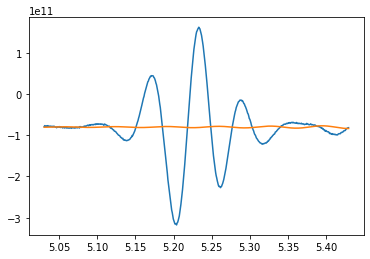

In [95]:
plt.plot(ra,data)
plt.plot(ra,f.bestfitmodel)